In [1]:
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

import time

from auxfunctions import *
from implementations import *

import warnings
warnings.filterwarnings('ignore')

## Figure 5 (b)

In [20]:
d = 1
n = 30
sup = 1

nu_1 = 1/2
nu_2 = 1/2
theta_1 = 5
theta_2 = 10

nu_12 = ( nu_1 + nu_2 ) / 2
theta_12 = min(theta_1, theta_2)
rho_12 = (theta_12**2/(theta_1*theta_2))**(d/2) * ( gamma(nu_1+d/2)*gamma(nu_2+d/2) / (gamma(nu_1)*gamma(nu_2)) )**(1/2) * gamma(nu_12)/gamma(nu_12+d/2)
rho_12

0.7071067811865476

In [21]:
X = gen_observation_points(d, n, sup)
X, X, Y_1, Y_2 = gen_observations(X, X, 
                                  matern_model(theta_1, nu_1), 
                                  matern_model(theta_2, nu_2),
                                  matern_model(theta_12, nu_12),
                                  rho_12)

In [22]:
X_test = np.linspace(0,1,101).reshape(101,1)
# X_test = gen_observation_points(d, 100, sup)

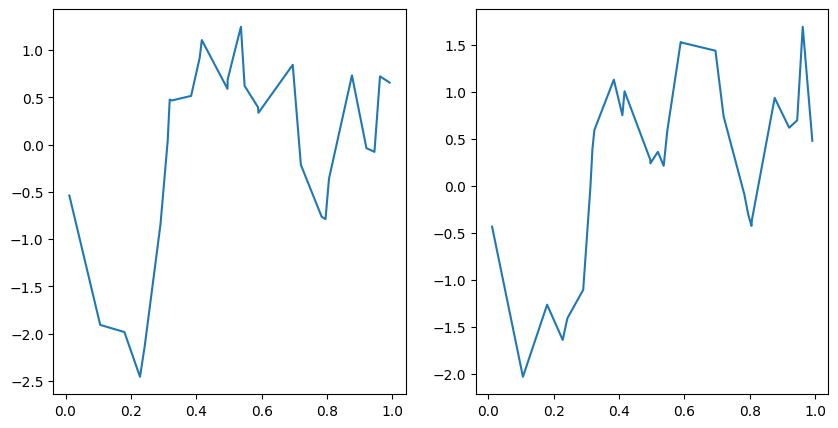

In [23]:
fig, axs = plt.subplots(1,2,figsize=(10,5))

sort_ind = np.argsort(X, axis=0).flatten()
axs[0].plot(X[sort_ind], Y_1[sort_ind])
axs[1].plot(X[sort_ind], Y_2[sort_ind]);

In [24]:
Ns = [2, 5]
As = [
    np.argsort(X, axis=0).reshape(15,2).tolist(),
    np.random.choice(np.arange(n), size=(n//2, 2), replace=False).tolist(),
    # np.random.choice(np.arange(n), size=(n//2, 2), replace=False).tolist()
      ]
rmses_NcoK = []
rmses_coKNN = []

num_iterations = 100

for _ in range(num_iterations):
    rmse_coKNN = np.zeros(len(Ns))
    rmse_NcoK = np.zeros(len(As))

    X = gen_observation_points(d, n, sup)
    X, X, Y_1, Y_2 = gen_observations(X,X,matern_model(theta_1,nu_1),matern_model(theta_2,nu_2),matern_model(theta_12,nu_12),rho_12)
    
# CO KRIGING
    sigma = K(X, X, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), 
              matern_model(theta_12, nu_12), rho_12)
    Y_coK = co_kriging(X_test, X, X, Y_1, Y_2, matern_model(theta_1, nu_1),
                matern_model(theta_12, nu_12), rho_12, sigma)

# CO KRIGING NN
    for i, N in enumerate(Ns):    
        coKNN = coKrigingNN(X, X, Y_1, Y_2, N, matern_model, theta_1, theta_2, 
                            theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = coKNN.predict(X_test)
        rmse_coKNN[i] += root_mean_squared_error(Y_coK, Y_pred)

# NESTED CO KRIGING
    for i, A in enumerate(As):
        NcoK = NestedCoKriging(X, X, Y_1, Y_2, matern_model, 
                                theta_1, theta_2, theta_12, nu_1,
                                nu_2, nu_12, rho_12)
        Y_pred = NcoK.predict(X_test, A, A)
        rmse_NcoK[i] += root_mean_squared_error(Y_coK, Y_pred)
    
    rmses_coKNN.append(rmse_coKNN)
    rmses_NcoK.append(rmse_NcoK)


rmses_coKNN = np.array(rmses_coKNN)
rmses_NcoK = np.array(rmses_NcoK)

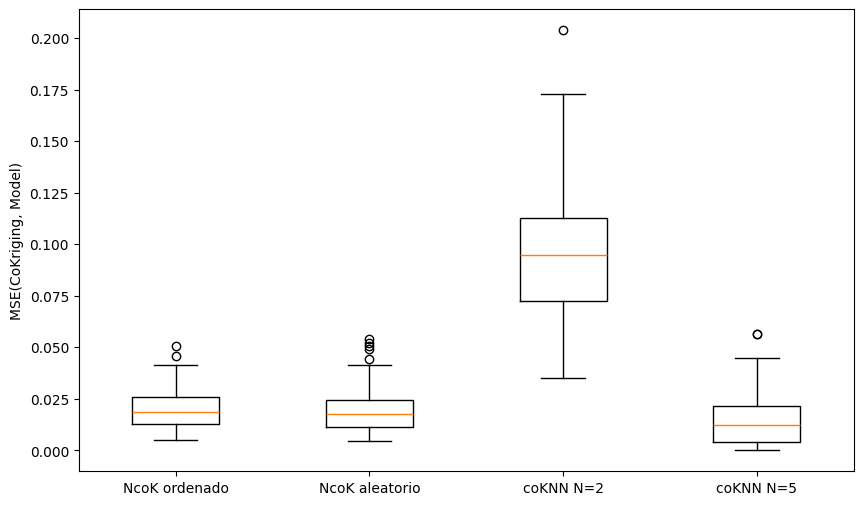

In [25]:
plt.figure(figsize=(10,6))

plt.boxplot(np.hstack([rmses_NcoK, rmses_coKNN]))

plt.xticks(range(1, 3 + len(Ns)), ['NcoK ordenado', 'NcoK aleatorio'] + [f'coKNN {N=}' for N in Ns])
plt.ylabel('MSE(CoKriging, Model)')
plt.show();

# n = 10_000

In [2]:
d = 2
n = 10_000
sup = 1

nu_1 = 1/2
nu_2 = 1/2
theta_1 = 4
theta_2 = 5

nu_12 = ( nu_1 + nu_2 ) / 2
theta_12 = min(theta_1, theta_2)
rho_12 = (theta_12**2/(theta_1*theta_2))**(d/2) * ( gamma(nu_1+d/2)*gamma(nu_2+d/2) / (gamma(nu_1)*gamma(nu_2)) )**(1/2) * gamma(nu_12)/gamma(nu_12+d/2)
rho_12

0.8

In [3]:
X = gen_observation_points(d, n, sup)
X, X, Y_1, Y_2 = gen_observations(X, X, 
                                  matern_model(theta_1, nu_1), 
                                  matern_model(theta_2, nu_2),
                                  matern_model(theta_12, nu_12),
                                  rho_12)

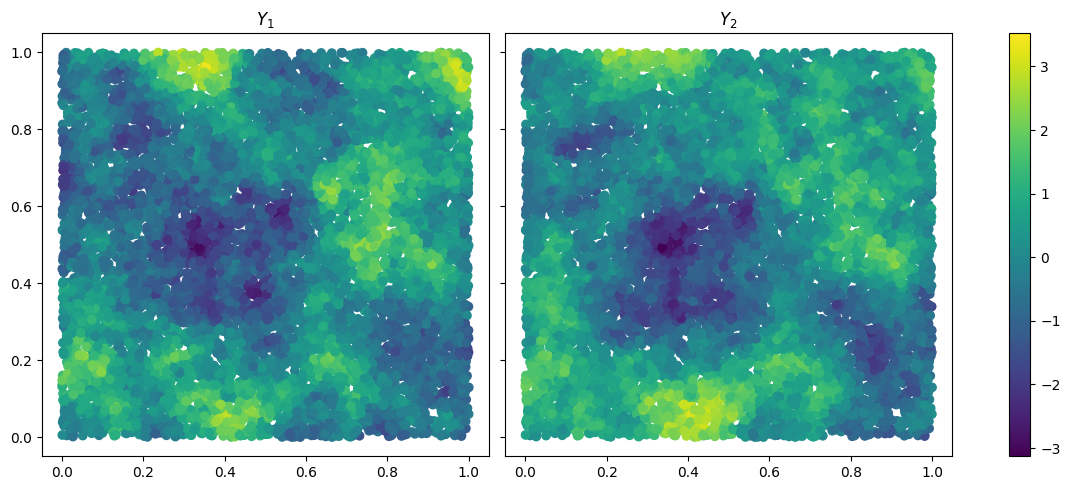

In [4]:
NestedCoKriging(X, X, Y_1, Y_2, cauchy_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12).plot_obs()

In [5]:
X_test = gen_observation_points(d, 100, sup)

In [20]:
Ns = [2, 10, 100]
As = [
    gen_A(X, 200),  # 50
    gen_A(X, 100),  # 100
    ]
rmses_NcoK = []
rmses_coKNN = []

num_iterations = 50

for _ in range(num_iterations):
    rmse_coKNN = np.zeros(len(Ns))
    rmse_NcoK = np.zeros(len(As))

    X = gen_observation_points(d, n, sup)
# CO KRIGING
    sigma = K(X, X, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), 
              matern_model(theta_12, nu_12), rho_12)
    
    Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, (n+n))
    Y_1, Y_2 = Y[:n], Y[n:]

    Y_coK = co_kriging(X_test, X, X, Y_1, Y_2, matern_model(theta_1, nu_1),
                matern_model(theta_12, nu_12), rho_12, sigma)

# CO KRIGING NN
    for i, N in enumerate(Ns):    
        coKNN = coKrigingNN(X, X, Y_1, Y_2, N, matern_model, theta_1, theta_2, 
                            theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = coKNN.predict(X_test)
        rmse_coKNN[i] += root_mean_squared_error(Y_coK, Y_pred)

# NESTED CO KRIGING
    for i, A in enumerate(As):
        NcoK = NestedCoKriging(X, X, Y_1, Y_2, matern_model, 
                                theta_1, theta_2, theta_12, nu_1,
                                nu_2, nu_12, rho_12)
        Y_pred = NcoK.predict(X_test, A, A)
        rmse_NcoK[i] += root_mean_squared_error(Y_coK, Y_pred)
    
    rmses_coKNN.append(rmse_coKNN)
    rmses_NcoK.append(rmse_NcoK)

rmses_coKNN = np.array(rmses_coKNN)
rmses_NcoK = np.array(rmses_NcoK)

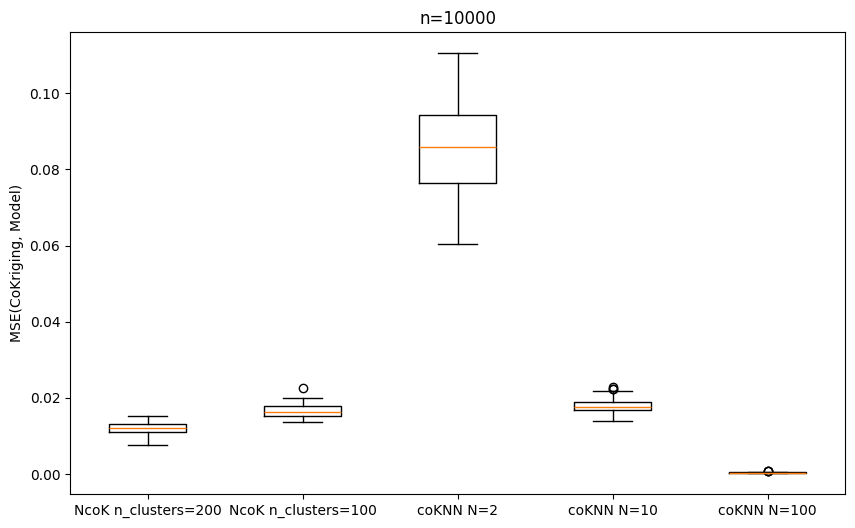

In [21]:
plt.figure(figsize=(10,6))

plt.boxplot(np.hstack([rmses_NcoK, rmses_coKNN]))

plt.xticks(range(1, 1 + len(As) + len(Ns)), [f'NcoK {n_clusters=}' for n_clusters in [200, 100]] + [f'coKNN {N=}' for N in Ns])
plt.ylabel('MSE(CoKriging, Model)')
plt.title(f'{n=}')
plt.show();